# **Part 1: ETF Analysis using QQQ**

## Define Business Problem, Objective, and Evaluation Process

**1. Business Problem**
Highly volatile financial markets make it difficult for investors and traders to predict price movements accurately. Thus, the opportunity is to leverage data analytics and machine learning to improve forecasting accuracy and identify profitable trading opportunities in ETFs like QQQ.

**2. Business Objective:** To develop a trading strategy and forecast the future performance of the QQQ ETF (Invesco QQQ Trust, which tracks the Nasdaq-100 Index)

**3. Business Goal:** To optimize portfolio allocation, improve trading strategies, and maximize returns for investors.

**4. Business Evaluation Process:**
   a. Utilize historical stock price data to compute key technical indicators (e.g., 10-day and 60-day moving averages).
   b. Generate trading signals (buy/sell) based on crossover strategies.
   c. Evaluate the effectiveness of the strategy by analyzing returns and comparing them to a baseline (e.g., buy-and-hold strategy).
   d. Visualize the results to identify trends and patterns.
   e. Explore the potential use of predictive models (e.g., time series forecasting) to enhance decision-making.

**5. Data Preparation:** Downloaded 5 years of QQQ ETF data, created necessary columns, and saved to CSV.

Evaluate the effectiveness of the strategy by analyzing the number of buy/sell signals and potential profitability.
   

### Step 1: Import required libraries

In [ ]:
# Install necessary libraries
#!pip install pyspark yfinance matplotlib pandas plotly

In [1]:

import yfinance as yf #To fetch stock data
import matplotlib.pyplot as plt #To visualize the results
import pyspark.pandas as ps # Pandas API for PySpark
from pyspark.sql import SparkSession # Create and manage Spark session
from pyspark.sql.functions import col 
from pyspark.sql.functions import to_date #Column operations in Spark
import pandas as pd

import os
os.environ["PYARROW_IGNORE_TIMEZONE"] = "1" # Avoid timezone issues in PyArrow

# find Spark and Python executables
import findspark
findspark.init()
findspark.find()

d:\Python_Files\envs\sparkenv\Lib\site-packages\pyspark\pandas\__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


'd:\\Python_Files\\envs\\sparkenv\\Lib\\site-packages\\pyspark'

In [2]:
# Initialize Spark session
spark = SparkSession.builder.getOrCreate()

In [3]:
#Call the data
bb = yf.Ticker("VOO") #using Vanguard S&P 500 ETF)

In [4]:
# Fetch 5 years of data
data = bb.history("5y")

In [5]:
# Ensure the Date column is present and reset the index
data.reset_index(inplace=True)

In [6]:
# Select necessary columns
etf_df = data[["Date", "Open", "High", "Low", "Close", "Volume"]]

In [ ]:
# Save to CSV
#etf_df.to_csv("etf_5y_data.csv", index=False)
#The above dataset attached is as per 05.05.25

In [82]:
# Enable operations on different dataframes
ps.set_option("compute.ops_on_diff_frames", True)

In [83]:
# ✅ Step 3: Convert Pandas DataFrame to PySpark DataFrame
etf_df = pd.DataFrame(etf_df)  # Convert to standard Pandas DF
etf_df = spark.createDataFrame(etf_df)  # Convert to PySpark DF

Since the dataset path is located in my local drive. The below code is for educcational purposes

In [24]:
# Load CSV into Pyspark on Pandas DataFrame
#etf_df = spark.read.csv("D:\Python Assignment\etf_5y_data.xls", header = True, inferSchema = True)

In [84]:
type(etf_df)

pyspark.sql.dataframe.DataFrame

The below code and model is run on data as per 04.03.25

In [85]:
# Display the schema and first few rows
etf_df.printSchema()
etf_df.show(5)

root
 |-- Date: timestamp (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: long (nullable = true)

+-------------------+------------------+------------------+------------------+------------------+--------+
|               Date|              Open|              High|               Low|             Close|  Volume|
+-------------------+------------------+------------------+------------------+------------------+--------+
|2020-03-05 05:00:00| 259.3497504134284| 262.2273168585585|255.01028906633948| 257.0828857421875| 6220000|
|2020-03-06 05:00:00|249.19045109413617|  253.946261763054| 246.6737486111021| 252.7711944580078| 6669100|
|2020-03-09 04:00:00| 234.9136966063784|241.48301835680482| 232.3784852129863|233.26673889160156|16425900|
|2020-03-10 04:00:00|242.14256866434624|245.23812866210938| 232.4003363515825|245.23812866210938|10879100|
|2020-03-11 04:00:00|238.5

In [86]:
# Manually convert "Date" column
#etf_df["Date"] = ps.to_datetime(etf_df["Date"])

# Convert the 'Date' column to datetime
etf_df = etf_df.withColumn("Date", to_date(col("Date")))


### Step 4: Calculate Moving Averages and Generate Trading Signals

In [87]:
# Convert the Spark DataFrame to a pandas-on-Spark DataFrame for easier manipulation
etf_df = etf_df.pandas_api()

In [95]:
# Calculate moving averages
etf_df["SMA_10"] = etf_df["Close"].rolling(window=10).mean()
etf_df["LMA_200"] = etf_df["Close"].rolling(window=200).mean()

Buy/Sell signals based on moving averages crossover:

- If SMA_10 > LMA_100 = 1 (BUY).
- If SMA_10 < LMA_100 = -1 (SELL).
- Otherwise = 0 (No action)

In [97]:
#Generate trading signals
etf_df["Signal"] = 0
etf_df.loc[etf_df["SMA_10"] > etf_df["LMA_200"], "Signal"] = 1  # Buy signal
etf_df.loc[etf_df["SMA_10"] < etf_df["LMA_200"], "Signal"] = -1  # Sell signal

In [98]:
# Count the number of buy and sell signals
etf_df.groupby("Signal").size().reset_index(name="count") #Counts the number of BUY (1) and SELL (-1) signals and No Action (0)

,Signal,count
0,-1,256
1,1,502
2,0,199


In [99]:
# Drop rows with NaN/missing values (due to rolling window)
etf_df.dropna(inplace=True)

### Step 5: Visualize the Results

In [100]:
# Convert the PySpark DataFrame to a Pandas DataFrame
etf_pd = etf_df.to_pandas()

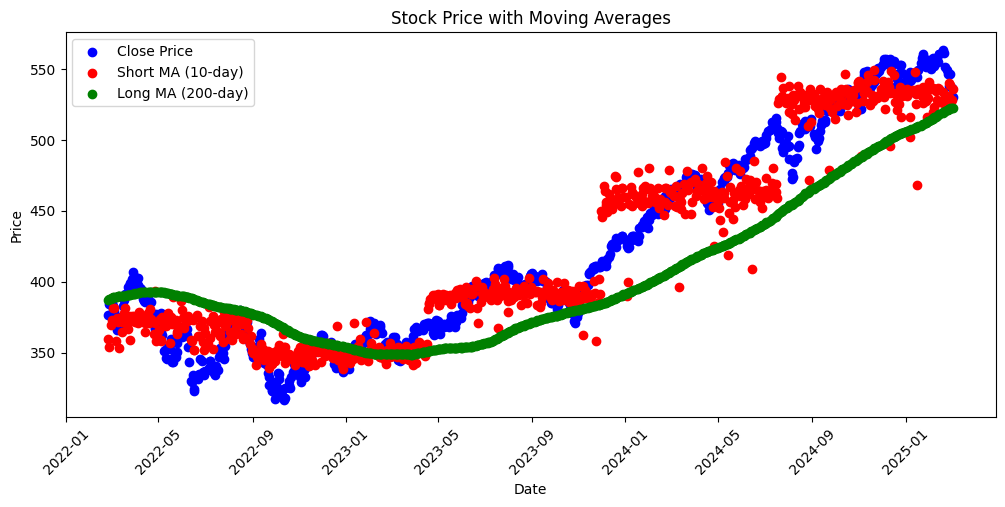

In [103]:
# Plot stock prices with moving averages
plt.figure(figsize=(12,5))
plt.scatter(etf_pd["Date"], etf_pd["Close"], label="Close Price", color='blue')
plt.scatter(etf_pd["Date"], etf_pd["SMA_10"], label="Short MA (10-day)", color='red')
plt.scatter(etf_pd["Date"], etf_pd["LMA_200"], label="Long MA (200-day)", color='green')
plt.legend()
plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Stock Price with Moving Averages")
# Reduce the number of x-axis labels (every 50th point)
plt.xticks(rotation=45) 
plt.show()

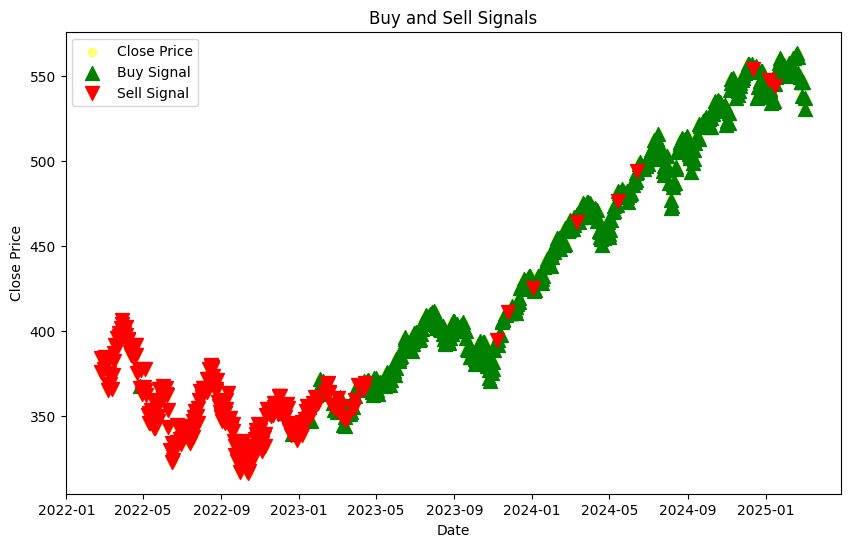

In [104]:
# Filter the data for Buy and Sell signals
buy_signals = etf_pd[etf_pd["Signal"] == 1]
sell_signals = etf_pd[etf_pd["Signal"] == -1]

# Plot Buy and Sell signals
plt.figure(figsize=(10, 6))
plt.scatter(etf_pd["Date"], etf_pd["Close"], label="Close Price", alpha=0.5, color='yellow')
plt.scatter(buy_signals["Date"], buy_signals["Close"], marker="^", color="g", s=100, label="Buy Signal")
plt.scatter(sell_signals["Date"], sell_signals["Close"], marker="v", color="r", s=100, label="Sell Signal")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("Buy and Sell Signals")
plt.legend()
plt.show()

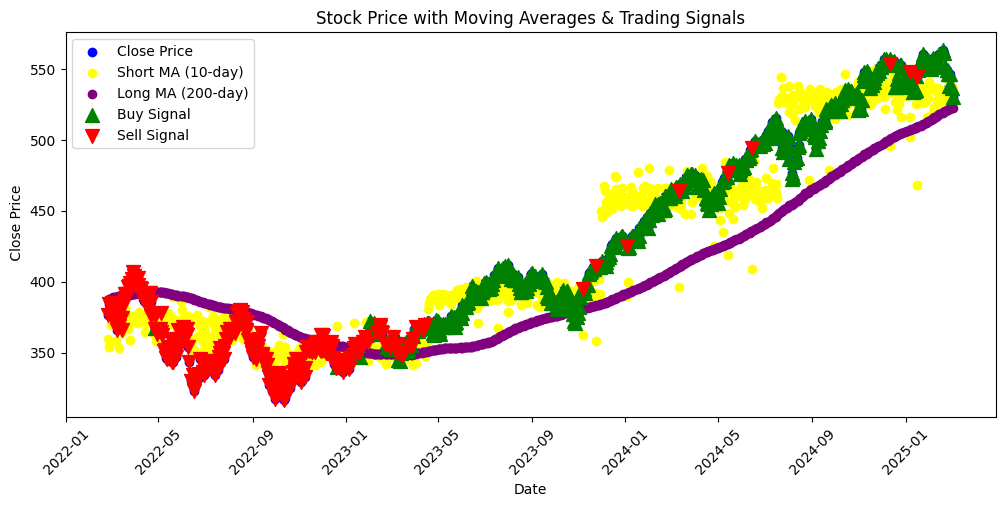

In [105]:
# Plot stock prices with moving averages
plt.figure(figsize=(12,5))
plt.scatter(etf_pd["Date"], etf_pd["Close"], label="Close Price", color='blue')
plt.scatter(etf_pd["Date"], etf_pd["SMA_10"], label="Short MA (10-day)", color='yellow')
plt.scatter(etf_pd["Date"], etf_pd["LMA_200"], label="Long MA (200-day)", color='purple')

# Filter the data for Buy and Sell signals
buy_signals = etf_pd[etf_pd["Signal"] == 1]
sell_signals = etf_pd[etf_pd["Signal"] == -1]

# Plot Buy and Sell signals
plt.scatter(buy_signals["Date"], buy_signals["Close"], marker="^", color="g", s=100, label="Buy Signal")
plt.scatter(sell_signals["Date"], sell_signals["Close"], marker="v", color="r", s=100, label="Sell Signal")

# Add labels and legend
plt.xlabel("Date")
plt.ylabel(" Close Price")
plt.title("Stock Price with Moving Averages & Trading Signals")
# Reduce the number of x-axis labels (every 50th point)
plt.xticks(rotation=45) 
plt.legend()

plt.show()

### Business Insights

1.The stock shows a long-term uptrend but with periods of significant volatility. Investors should be cautious during high-fluctuation periods
2. The 10-day MA (yellow) closely follows close price movements, while the 200-day MA (green) acts as strong support/resistance.

Business Recommendations:

1. Long-Term Investors: Follow the 200-day MA trend for entry/exit points to avoid short-term noise.
2. Short-Term Traders: Leverage buy/sell signals but validate with additional indicators (e.g., RSI, MACD) to minimize false signals.
3. Risk Management: Implement stop-loss strategies due to market fluctuations.

### Step 6: Analyze the Profitability

In [106]:
etf_pd.head()

,Date,Open,High,Low,Close,Volume,SMA_10,LMA_200,Signal
541,2022-04-27,367.624136,372.656800,365.706931,367.652893,6415700,393.486292,392.861750,1
558,2022-05-20,346.448591,346.966244,335.280876,343.198914,8755900,389.509442,390.821855,-1
502,2022-03-02,379.975747,386.071109,379.077683,384.638031,8185200,388.247763,388.632683,-1
564,2022-05-31,364.489529,367.001064,361.316557,363.962280,5016500,386.651910,389.881545,-1
588,2022-07-06,338.069688,341.390402,335.855850,339.128448,5450900,381.825882,384.172431,-1


In [107]:
# Extract Buy and Sell signals
buy_prices = etf_pd[etf_pd["Signal"] == 1]["Close"].values  #Get Close price where Signal = 1
sell_prices = etf_pd[etf_pd["Signal"] == -1]["Close"].values  #Get Close price where Signal = -1

In [108]:
# Ensure buy and sell signals match correctly (equal length)
num_trades = min(len(buy_prices), len(sell_prices))  #Match pairs of Buy & Sell
buy_prices = buy_prices[:num_trades]  #Adjust to match sell length
sell_prices = sell_prices[:num_trades]  #Adjust to match buy length

In [109]:
# Check the data type of buy_prices and sell_prices
print(f"Buy Prices Data Type: {buy_prices.dtype}")
print(f"Sell Prices Data Type: {sell_prices.dtype}")

Buy Prices Data Type: float64
Sell Prices Data Type: float64


In [110]:
# Calculate profits per trade
profits = sell_prices - buy_prices

sum(profits)

-10739.925323486328

### Business Insights

A loss of -10,739.93 per trade, indicating that the selling prices are significantly lower than the buying prices. This loss price can indicate some of the following:

1. Negative profitability: The strategy is currently unprofitable, with losses incurred per trade.
2. Ineffective Timing: Buy signals may be occurring at high prices, and sell signals at low prices.
3. Risk Exposure: High losses suggest poor risk management or unfavorable market conditions.
4. Strategy Review: We can try and re-evaluate the moving average crossover strategy or incorporate additional indicators for better model accuracy.
5. Unfavourable Market Conditions: Assess if the losses are due to a bearish market or strategy flaws.

To conclude, our strategy needs refinement to improve profitability and reduce losses.

### Question 2: Time-series Forecasting using Prophet Model

### Step 1: Install and Import necessary libraries

In [ ]:
#Install Necessary library
#!pip install prophet pandas scikit-learn numpy

In [45]:
# Import required libraries
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt

# Don't print warnings
import warnings
warnings.filterwarnings('ignore')

d:\Python_Files\envs\sparkenv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Step 2: Load and Prepare the Data for Prophet Model

The Prophet Model requires two columns:
1. Time Component > Date (ds)
2. Forecast Value > Stock Close Price (y)

In [46]:
# Select relevant columns (Date and Close) & rename them for Prophet
df = etf_pd[["Date", "Close"]].rename(columns={"Date": "ds", "Close": "y"})

In [47]:
# Ensure the 'ds' column is in datetime format
df["ds"] = pd.to_datetime(df["ds"])

In [48]:
# Display the first few rows
print(df.head())

            ds           y
158 2020-10-19  294.822540
178 2020-11-16  312.492950
234 2021-02-08  338.335358
239 2021-02-16  339.880707
279 2021-04-14  357.645721


In [49]:
df = df[df["ds"].notna()]  # Remove any NaT values after conversion

## Step 3: Split the data into Test (20%) and Training sets (80%)

In [50]:
 #80% for training, 20% for testing
train_size = int(len(df) * 0.8)  

train = df[:train_size]

test = df[train_size:]

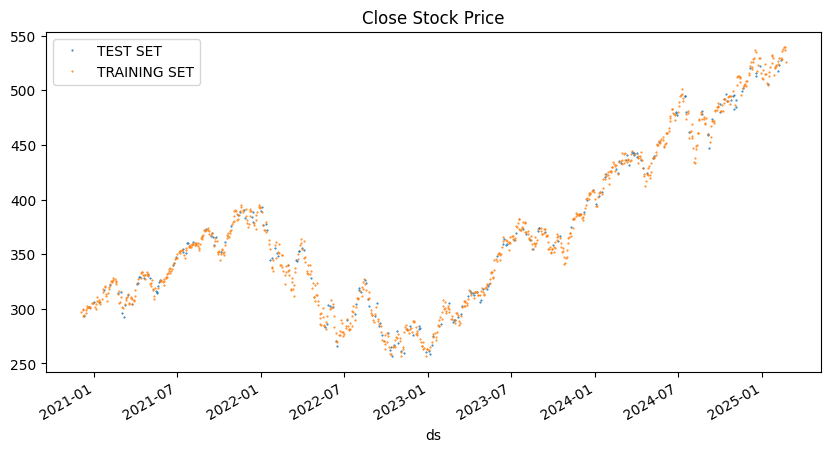

In [52]:
# Plot train and test to see where we have split
test \
    .rename(columns={'y': 'TEST SET'}) \
    .merge(train.rename(columns={'y': 'TRAINING SET'}), 
           on='ds', how='outer', suffixes=('_test', '_train')) \
    .set_index('ds') \
    [['TEST SET', 'TRAINING SET']] \
    .plot(figsize=(10, 5), title='Close Stock Price', style='.', ms=1)

plt.show()

## Step 4: Train the Prophet Model

In [51]:
# Initialize Prophet model with yearly and weekly seasonality
model = Prophet(yearly_seasonality=True, weekly_seasonality=True)

In [52]:
# Fit the model on the QQQ data
model.fit(train)

22:25:01 - cmdstanpy - INFO - Chain [1] start processing
22:25:02 - cmdstanpy - INFO - Chain [1] done processing


### Step 5: Generate Dates Forecast

In [53]:
# Dates based on the test dataset
future = pd.DataFrame({'ds': test['ds']})

In [54]:
# Generate forecasts using Prophet
test_forecast = model.predict(future)

In [56]:
# Display the forecasted prices
print(test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(30)) # yhat → Predicted stock price.
                                                                     #yhat_lower, yhat_upper → Confidence interval for prediction

            ds        yhat  yhat_lower  yhat_upper
182 2025-01-21  548.416933  515.540712  576.653305
183 2025-01-22  549.216058  516.041305  579.735480
184 2025-01-23  549.800239  517.146102  580.545686
185 2025-01-24  550.612208  516.819864  581.880027
186 2025-01-27  553.289669  519.280154  583.837932
187 2025-01-28  553.585115  519.703436  584.844896
188 2025-01-29  554.726659  518.341561  586.431067
189 2025-01-30  555.597865  519.365208  588.399530
190 2025-01-31  556.633039  520.966599  589.377634
191 2025-02-03  559.535258  524.018687  592.653510
192 2025-02-04  559.745187  522.044132  594.111602
193 2025-02-05  560.719513  524.375924  594.681572
194 2025-02-06  561.343742  525.344536  594.413767
195 2025-02-07  562.055978  524.435691  596.939879
196 2025-02-10  563.597392  525.743611  597.107842
197 2025-02-11  563.251865  525.466957  600.265396
198 2025-02-12  563.637293  522.984004  599.499431
199 2025-02-13  563.651031  523.540796  599.662205
200 2025-02-14  563.743564  522

In [57]:
# Plot the forecast with the actuals
#f, ax = plt.subplots(figsize=(15, 5))
#ax.scatter(test.index, test['y'], color='r')
#fig = model.plot(test_forecast, ax=ax)

## Step 6: Evaluate the Model

Evaluate the performance of the model by comparing ture and predicted values on test data.

In [93]:
### Import necessaries library
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import numpy as np

Here, two metrics are used to measure how well our forecasted prices match actual prices:

1. Mean Absolute Error (MAE) > Measures average absolute difference between actual and predicted values.
2. Root Mean Squared Error (RMSE) > Measures how much predicted prices deviate from actual prices

In [94]:
# Ture values
actual = test['y'].values

# Predicted values
predicted = test_forecast['yhat'].values

mae = mean_absolute_error(actual, predicted)
mse = mean_squared_error(actual, predicted)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(actual, predicted)

print(f"MAE: {mae}")
print(f"MSE: {mse}")
print(f"RMSE: {rmse}")
print(f"MAPE:{mape}")

MAE: 25.34188662622743
MSE: 1007.9368261377007
RMSE: 31.74802082237097
MAPE:0.04960810786595796


Interpretation:

1. MAE (Mean Absolute Error): 25.34 > predictions are off by ~25.34 units.

Insight: Moderate error; need improvement for precise forecasting

2. MSE (Mean Squared Error): 1007.94 > indicating significant outliers.

Insight: This high MSE suggests occasional large prediction errors, impacting decision-making.

3. RMSE (Root Mean Squared Error): 31.75 > Similar to MAE but scaled to the data.

Insight: Predictions deviate by ~31.75 units on average.

4. MAPE (Mean Absolute Percentage Error): 4.96% > Predictions are off by ~4.96% on average.

Insight: Good accuracy for business forecasting, as errors below 5% are generally acceptable.

*Business Insights:*
1. Accuracy: The model performs reasonably well (MAPE < 5%), but MAE and RMSE indicate room for improvement.
2. Outliers: High MSE suggests occasional large errors, which could lead to poor decisions in critical scenarios.
3. Reliability: The model is reliable for general trend analysis but may struggle with precise predictions.

Recommendations:
1. Improve Model: Incorporate additional features, use advanced algorithms (e.g., ARIMA, LSTM), or tune hyperparameters to reduce errors.
2. Outlier Analysis: The model needs to investigate and address outliers to improve MSE and RMSE.
3. Error Monitoring: Continuously monitor MAE and MAPE should be done to track performance over time.

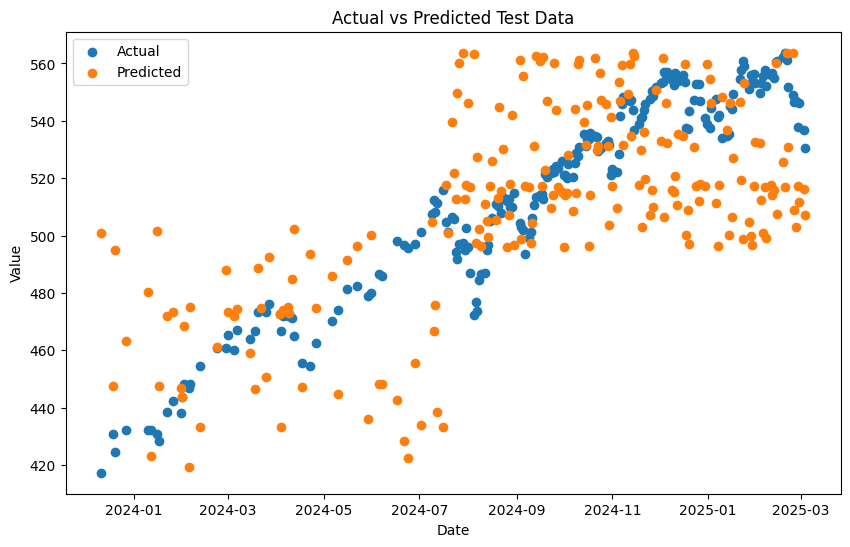

In [ ]:
#Visualize Actual vs Predicted Test Data
import matplotlib.pyplot as plt


plt.figure(figsize=(10, 6))
plt.scatter(test['ds'], actual, label='Actual')
plt.scatter(test['ds'], predicted, label='Predicted')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs Predicted Test Data')
plt.show()

Deploy the Model: Predict into Future (30 days)

In [ ]:
# Make prediction in future
future = model.make_future_dataframe(periods=30)

forecasted = model.predict(future)
forecasted ['yhat']

0      288.436923
1      288.349019
2      289.091421
3      290.196530
4      292.083844
          ...    
870    518.029847
871    517.450370
872    517.675001
873    517.602798
874    517.683936
Name: yhat, Length: 875, dtype: float64

### Visualize the actual, predicted, and forecasted data

Plot the actual and test forecasted data

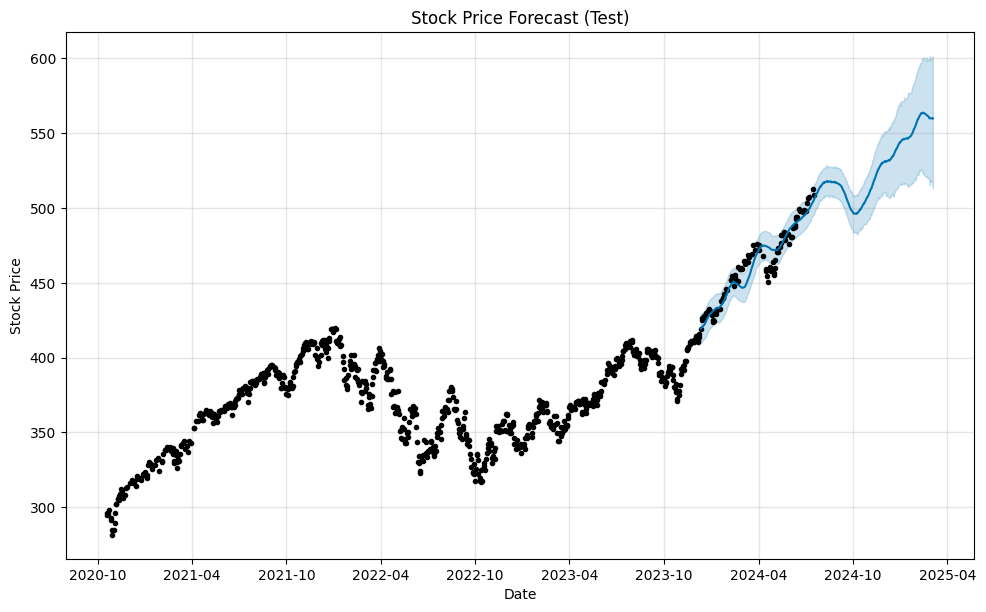

In [112]:
fig = model.plot(test_forecast)
plt.title("Stock Price Forecast (Test)")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.show()

Plot the components of test forecast model include future trend and seasonality behaviour.

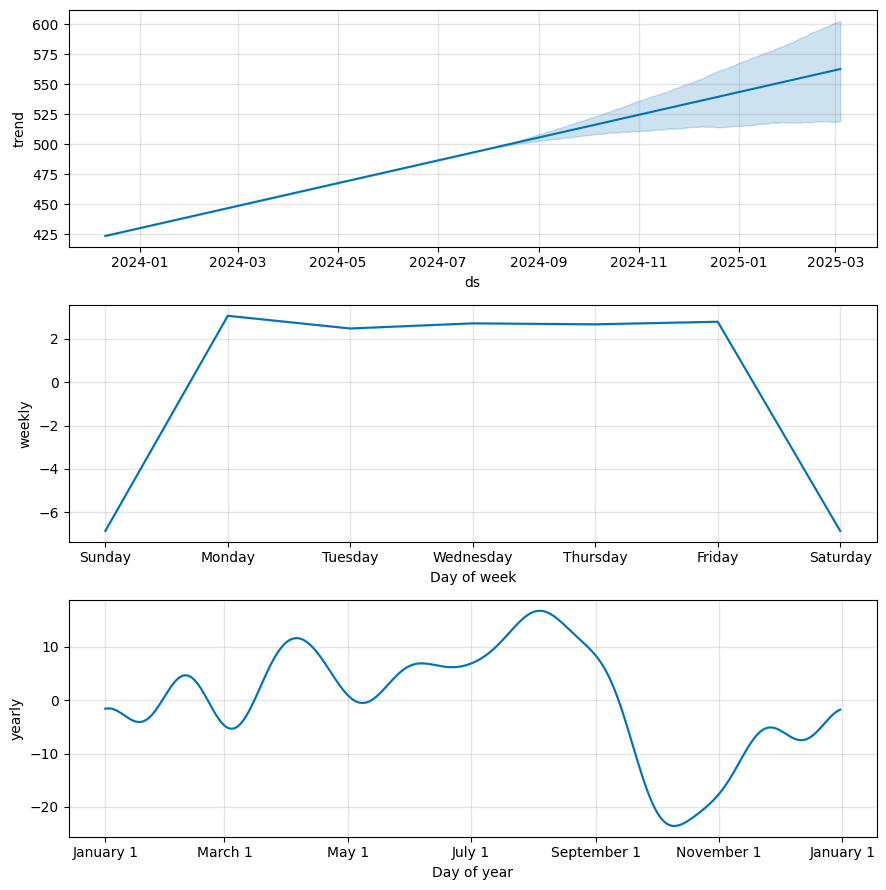

In [65]:
fig2 = model.plot_components(test_forecast)

Plot the Predicted Data

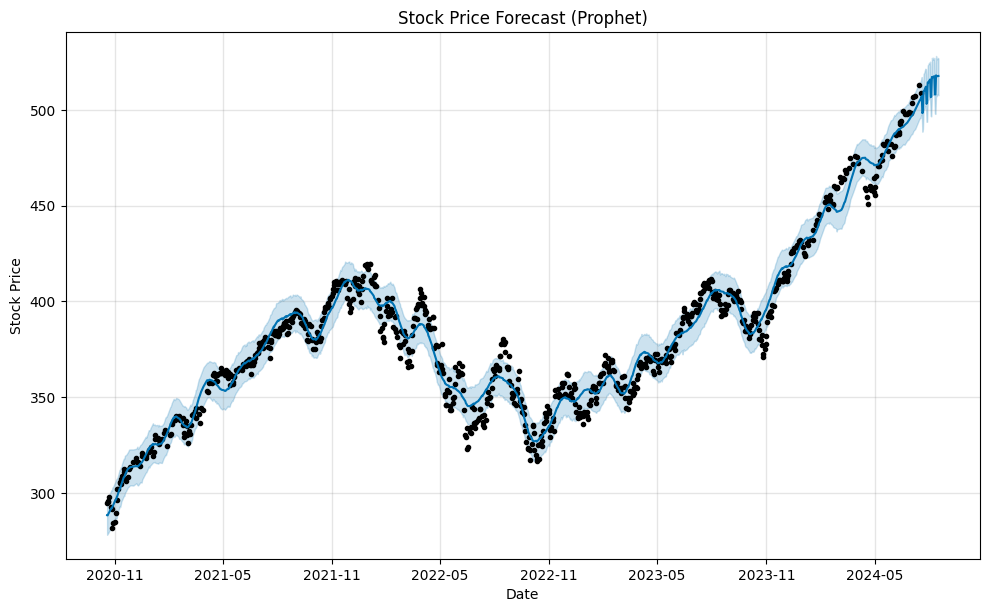

In [113]:
fig3 = model.plot(forecasted)
plt.title("Stock Price Forecast (Prophet)")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.show()

In [114]:
# Blue line > Predicted stock price.
# Shaded area > Confidence interval (uncertainty range).

### Key insights

1. **Makret Trend**: The stock price shows an overall upward trend, with fluctuations.  
2. **Forecast**: The prophet model predicts continued growth, reaching around 500 by mid-2024.  
3. **Volatility**: There are periodic dips and recoveries in the trend that suggests market volatility.  
4. **Confidence**: The shaded area around the forecast line indicates uncertainty, wider in the future.  
5. **Business Insight**: The forecast suggests a bullish outlook, however tha volatility requires cautious planning.  

In summary, the model predicts growth, but businesses should prepare for potential fluctuations.

Plot the components of predicted forecast model include future trend and seasonality behaviour

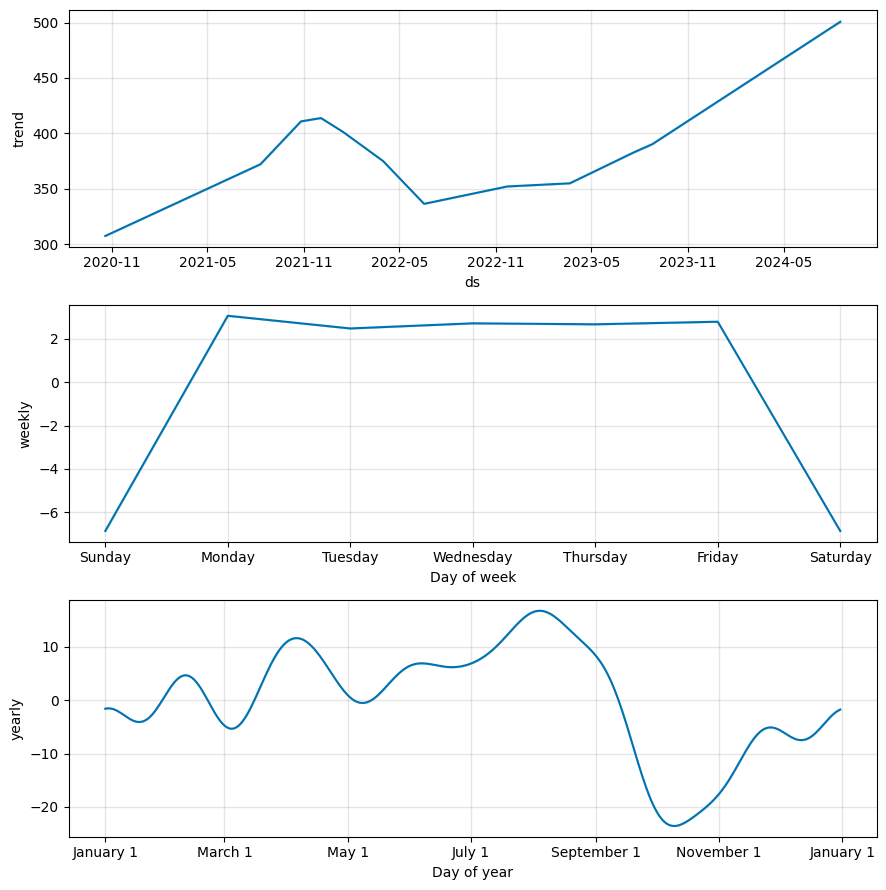

In [ ]:
#Plot trend, seasonality and other components
fig4 = model.plot_components(forecasted)

### Interpretation:

1. Forecast Trend: The stock price is predicted to rise from around 300 in late 2020 to approximately 500 by mid-2024, indicating a bullish behaviour.
2. Weekly Trends: The stock price is higher on weekdays and lower on weekends(Saturday and Sunday) > suggests buying during weekends and sellling during weekdays
3. Yearly Trends: The yearly component shows seasonal fluctuations, with peaks and troughs at specific times of the year > higher volatility around mid-year and drop significantly during off season (November)

## Export Model

In [68]:
!pip install jsonpickle

In [69]:
import jsonpickle

In [70]:
# Define relative path to save model
model_path = "D:/Python Assignment/prophet_model.json"

In [71]:
# Convert model to JSON format
model_json = jsonpickle.encode(model)

In [72]:
# Save JSON model to file
with open(model_path, "w") as f:
    f.write(model_json)
print("Prophet model saved successfully as JSON!")

Prophet model saved successfully as JSON!


### Reload to model to check if it works

In [73]:
# Load JSON model
with open(model_path, "r") as f:
    loaded_model_json = f.read()

In [75]:
# Decode JSON back into Prophet model
loaded_model = jsonpickle.decode(loaded_model_json)

print("Prophet model reloaded!")

Prophet model reloaded!


### END NOTEBOOK